In [1]:
# Cell 1: Install required packages (run once)

# Faker → Generate realistic fake names, addresses, phone numbers, emails, etc.
# Essential for creating human-like synthetic data (Indian names, cities, VINs, etc.)
!pip install -q Faker

# pandas → Core data manipulation library (DataFrames, CSV I/O, cleaning)
# Used everywhere: building datasets, adding columns, saving results
!pip install -q pandas

# scikit-learn → For quick baseline modeling (LinearRegression, R² evaluation)
# Used in the Validator agent to compute realistic R² scores on generated data
!pip install -q scikit-learn

# pyyaml → Save/load structured metadata (task description, schema, source links)
# Creates clean metadata_*.yaml files alongside every generated CSV
!pip install -q pyyaml

# tqdm → Beautiful progress bars when generating large datasets or looping
# Makes long synthetic data generation feel responsive in notebooks
!pip install -q tqdm

# requests → Download real datasets from URLs (Kaggle, GitHub, data.gov.in, etc.)
# Used when the agent finds an existing dataset and wants to fetch it automatically
!pip install -q requests

# python-dateutil → Smart parsing of dates in any format (e.g., "2025", "Mar-25", "next year")
# Helpful when generating realistic "year", "registration_date", or "listing_date" columns
!pip install -q python-dateutil

# Optional: google-generativeai → Use Gemini models (flash/pro) for reasoning & fact gathering
# Only needed if you want full LLM-powered schema/fact tools (highly recommended for judges)
# The "|| true" makes the install non-blocking if PyPI is temporarily down
!pip install -q google-generativeai || true

print("All required and optional packages installed successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 33.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 8.8 MB/s eta 0:00:00:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
google-cloud-translate 3.12.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.29.5 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
pydrive2 1.21.3 requires cryptography<44, but you have cryptography 46.0.3 which is incompatible.
pydrive2 1.21.3 requires pyOpenSSL<=24.2.1,>=19.1.0, but you have pyopenssl 25.3.0 which

In [13]:
# Cell 2: set API keys for Gemini if you want LLM-powered behaviors.
# Do NOT hardcode your key in shared notebooks. Use getpass or Colab secrets.
import os
from getpass import getpass

# If you want Gemini/Large model features, paste here (won't echo):
if "GEMINI_API_KEY" not in os.environ and "GOOGLE_API_KEY" not in os.environ:
    print("If you want LLM-assisted schema generation, paste GEMINI/GOOGLE API key now (it will not be shown).")
    k = getpass("GEMINI/GOOGLE API KEY (press Enter to skip): ")
    if k:
        os.environ["GEMINI_API_KEY"] = k
        os.environ["GOOGLE_API_KEY"] = k
        print("API key set in session (temp).")

print("GEMINI available:", bool(os.environ.get("GEMINI_API_KEY") or os.environ.get("GOOGLE_API_KEY")))


GEMINI available: True


In [14]:
# Cell 3: imports and utilities
import os, json, uuid, datetime, time, random, math
from typing import List, Dict, Any
from faker import Faker
import pandas as pd
from tqdm import tqdm
import yaml
import requests
from concurrent.futures import ThreadPoolExecutor, as_completed
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np

fake = Faker()
SEED = 12345
random.seed(SEED)
np.random.seed(SEED)

def now_iso():
    return datetime.datetime.now(datetime.timezone.utc).isoformat()

def save_csv(df, path):
    df.to_csv(path, index=False)
    return path

def save_yaml(obj, path):
    with open(path, "w") as f:
        yaml.safe_dump(obj, f, sort_keys=False)
    return path

# small safe HTTP fetch with timeouts
def safe_get(url, timeout=8):
    try:
        r = requests.get(url, timeout=timeout)
        return r.status_code, r.content
    except Exception as e:
        return None, str(e)


In [15]:
# Cell 4: Memory & session (persisted to file optional)
class InMemorySessionService:
    def __init__(self):
        self.sessions = {}
    def new_session(self, session_id=None):
        sid = session_id or str(uuid.uuid4())[:8]
        self.sessions[sid] = {"history": [], "state": {}, "created_at": now_iso()}
        return sid
    def append(self, session_id, role, message):
        self.sessions[session_id]["history"].append({"ts": now_iso(), "role": role, "message": message})
    def set_state(self, session_id, key, value):
        self.sessions[session_id]["state"][key] = value
    def get_state(self, session_id):
        return self.sessions[session_id]["state"]
    def get_history(self, session_id):
        return self.sessions[session_id]["history"]

# Simple persistent preference memory for user (optional)
PREFS_PATH = "/content/.dataforge_prefs.json"
def load_prefs():
    if os.path.exists(PREFS_PATH):
        return json.load(open(PREFS_PATH))
    return {}
def save_prefs(p):
    json.dump(p, open(PREFS_PATH,"w"), indent=2)

session_store = InMemorySessionService()
prefs = load_prefs()


In [16]:
# Cell 5: Agent base class and TopicExpanderAgent (LLM-assisted if available)
USE_GEMINI = False
try:
    from google import genai
    if os.environ.get("GEMINI_API_KEY") or os.environ.get("GOOGLE_API_KEY"):
        client = genai.Client()
        USE_GEMINI = True
except Exception:
    USE_GEMINI = False

class Agent:
    def __init__(self, name):
        self.name = name
    def log(self, session_id, msg):
        session_store.append(session_id, self.name, msg)

class TopicExpanderAgent(Agent):
    def __init__(self):
        super().__init__("TopicExpander")
    def expand(self, session_id, user_prompt, n_queries=10):
        self.log(session_id, f"Expanding prompt: {user_prompt}")
        # Try LLM first
        if USE_GEMINI:
            try:
                # Simple instruction to get schema & queries — editable
                instr = f"""
You are dataset design assistant. Given: {user_prompt}
Return a JSON with keys:
- queries: list of {n_queries} search query strings (short)
- schema_columns: list of {{name,type,description,example}}
- target: name of target variable to predict (if applicable) or null
- biases: list of possible bias risks (1-3)
Return only JSON.
"""
                resp = client.models.generate_content(model="gemini-2.5-flash", contents=instr)
                txt = resp.text
                # extract JSON
                import re
                m = re.search(r'(\{.*\})', txt, re.S)
                jtxt = m.group(1) if m else txt
                j = json.loads(jtxt)
                self.log(session_id, "Used Gemini for expansion")
                return j
            except Exception as e:
                self.log(session_id, f"LLM expansion failed: {e}; falling back")
        # Fallback heuristic expansion
        queries = []
        base = user_prompt.lower()
        for w in ["dataset", "csv", "data", "open dataset", "public data"]:
            queries.append(f"{user_prompt} {w}")
            if len(queries) >= n_queries:
                break
        # Simple heuristic schema
        schema_cols = [
            {"name":"id","type":"int","description":"unique id","example":1},
            {"name":"feature_1","type":"float","description":"auto feature","example":0.0},
            {"name":"feature_2","type":"float","description":"auto feature","example":0.0},
            {"name":"price","type":"float","description":"target price if applicable","example":1000.0}
        ]
        biases = ["sample bias", "instrumentation bias"]
        out = {"queries": queries[:n_queries], "schema_columns": schema_cols, "target": "price", "biases": biases}
        self.log(session_id, "Used heuristic expansion")
        return out

# quick test
topic_agent = TopicExpanderAgent()


Both GOOGLE_API_KEY and GEMINI_API_KEY are set. Using GOOGLE_API_KEY.


In [17]:
# Cell 6: SourceScoutSwarm
class SourceScoutSwarm(Agent):
    def __init__(self, max_workers=6, simulate_failure=True):
        super().__init__("SourceScout")
        self.max_workers = max_workers
        self.simulate_failure = simulate_failure
        # Pre-populated candidate endpoints (real implementation could use tool calls)
        self.known_sources = [
            {"name":"HuggingFace","url_template":"https://huggingface.co/datasets?q={q}"},
            {"name":"Kaggle","url_template":"https://www.kaggle.com/search?q={q}"},
            {"name":"InsideAirbnb","url_template":"http://insideairbnb.com/get-the-data.html?q={q}"},
            {"name":"DataGov","url_template":"https://data.gov/search?query={q}"}
        ]
    def scout_one(self, q):
        # Simulate fetching candidate link(s) for a query
        cand = []
        for s in self.known_sources:
            url = s["url_template"].format(q=requests.utils.quote(q))
            # Simulate failure rate if requested
            if self.simulate_failure and random.random() < 0.7:
                # simulate blocked (no candidate)
                continue
            # else create a synthetic candidate link (in real: scrape results)
            cand.append({"source": s["name"], "url": url, "license":"unknown"})
        return cand

    def scout(self, session_id, queries: List[str], timeout_per_query=3):
        self.log(session_id, f"Starting scout for {len(queries)} queries")
        candidates = []
        with ThreadPoolExecutor(max_workers=self.max_workers) as ex:
            futures = {ex.submit(self.scout_one, q): q for q in queries}
            for fut in tqdm(as_completed(futures), total=len(futures), desc="SourceScout"):
                q = futures[fut]
                try:
                    res = fut.result(timeout=timeout_per_query)
                    if res:
                        candidates.extend(res)
                        self.log(session_id, f"Found {len(res)} candidates for query: {q}")
                except Exception as e:
                    self.log(session_id, f"Scout error for {q}: {e}")
        # de-duplicate by url
        unique = {c['url']: c for c in candidates}.values()
        self.log(session_id, f"Scout finished. {len(list(unique))} unique candidates.")
        return list(unique)

# quick instantiate
scout = SourceScoutSwarm(simulate_failure=True)


In [19]:
# Cell 7: EthicalGatekeeperAgent
class EthicalGatekeeperAgent(Agent):
    def __init__(self, allowed_license_patterns=None):
        super().__init__("EthicalGatekeeper")
        # what we accept as open
        self.allowed_license_patterns = allowed_license_patterns or ["cc", "public", "odc-pddl", "pd"]
    def vet(self, session_id, candidates: List[Dict[str,Any]]):
        accepted = []
        rejected = []
        for c in candidates:
            reason = None
            # heuristics: if url contains 'kaggle' require login => reject (simulated)
            url = c.get("url","")
            if "kaggle.com" in url and "datasets" in url:
                reason = "kaggle-may-require-login"
            # if license field contains unknown => reject
            lic = c.get("license","unknown").lower()
            if lic == "unknown":
                # attempt a naive check: accept HF and DataGov
                if "huggingface" in url or "data.gov" in url or "insideairbnb" in url:
                    accepted.append({**c, "license":"open (heuristic)", "vet_note":"accepted by heuristic"})
                    continue
                else:
                    reason = "license-unknown"
            # If license explicitly forbidden
            if any(p in lic for p in ["proprietary","commercial"]):
                reason = "license-forbidden"
            if reason:
                rejected.append({**c, "rejection_reason": reason})
            else:
                accepted.append(c)
        self.log(session_id, f"Gatekeeper accepted {len(accepted)}; rejected {len(rejected)}")
        return accepted, rejected

gatekeeper = EthicalGatekeeperAgent()


In [20]:
# Cell 8: DataHarvester & Cleaner
class DataHarvesterCleanerAgent(Agent):
    def __init__(self):
        super().__init__("HarvesterCleaner")
    def download_and_read(self, session_id, candidate):
        url = candidate.get("url")
        self.log(session_id, f"Attempting download: {url}")
        # In real system attempt to fetch direct download; here try safe_get and attempt to parse CSV
        status, content = safe_get(url)
        if status is None or (isinstance(status,int) and status >= 400) or status is None:
            self.log(session_id, f"Failed to download {url} (status={status})")
            return None, {"url":url, "status":status}
        # heuristics: if content small, treat as non-data
        try:
            txt = content.decode("utf-8", errors="ignore")
            # try pandas read_csv from text
            from io import StringIO
            df = pd.read_csv(StringIO(txt))
            self.log(session_id, f"Downloaded & parsed CSV from {url} with {len(df)} rows")
            return df, {"url":url, "status":status}
        except Exception as e:
            self.log(session_id, f"Could not parse as CSV: {e}")
            return None, {"url":url, "status":status, "error":str(e)}
    def merge_and_clean(self, session_id, dfs: List[pd.DataFrame], target_schema: Dict[str,Any]=None):
        if not dfs:
            return None, {"error":"no_data"}
        # naive merge: concat, dedupe, basic cleaning
        full = pd.concat(dfs, ignore_index=True, sort=False)
        # drop exact duplicate rows
        before = len(full)
        full = full.drop_duplicates()
        after = len(full)
        # basic type coercions for numeric-like columns
        for c in full.columns:
            if full[c].dtype == object:
                # try convert to numeric if many numeric-looking values
                try:
                    full[c] = pd.to_numeric(full[c].str.replace(",",""), errors="ignore")
                except Exception:
                    pass
        # If target schema provided, attempt to align columns (rename heuristics)
        if target_schema:
            # try to match on similar names (very naive)
            cols_req = [col["name"] for col in target_schema]
            mapping = {}
            for want in cols_req:
                # find best match
                for have in full.columns:
                    if want.lower() in have.lower() or have.lower() in want.lower():
                        mapping[have] = want
                        break
            if mapping:
                full = full.rename(columns=mapping)
        self.log(session_id, f"Merged {len(dfs)} datasets -> {before} -> deduped {after} rows -> {len(full)} rows after cleaning")
        return full, {"merged_rows": len(full), "deduped": before-after}

harvester = DataHarvesterCleanerAgent()


In [22]:
# Cell 9: ValidatorEnricherLoopAgent
class ValidatorEnricherLoopAgent(Agent):
    def __init__(self, r2_threshold=0.5):
        super().__init__("ValidatorEnricher")
        self.r2_threshold = r2_threshold
    def evaluate_baseline(self, session_id, df, target_col="price", seed=SEED):
        # simple numeric feature selector and LinearRegression baseline
        self.log(session_id, f"Running baseline evaluation on {len(df)} rows")
        if target_col not in df.columns:
            self.log(session_id, f"Target {target_col} not found; cannot evaluate")
            return {"ok": False, "reason":"target_missing"}
        # Prepare X numeric features
        X = df.select_dtypes(include=[np.number]).copy()
        if target_col in X.columns:
            X = X.drop(columns=[target_col])
        y = df[target_col].fillna(0)
        if X.shape[1] == 0:
            self.log(session_id, "No numeric features available for baseline")
            return {"ok": False, "reason":"no_numeric_features"}
        try:
            X_train, X_test, y_train, y_test = train_test_split(X.fillna(0), y, test_size=0.2, random_state=seed)
            model = LinearRegression()
            model.fit(X_train, y_train)
            r2 = model.score(X_test, y_test)
            self.log(session_id, f"Baseline R2: {r2:.3f}")
            return {"ok": True, "r2": float(r2)}
        except Exception as e:
            self.log(session_id, f"Baseline failure: {e}")
            return {"ok": False, "reason": str(e)}

validator = ValidatorEnricherLoopAgent(r2_threshold=0.5)


In [23]:
# Cell 10: Synthetic fallback - task-aware generator
class TaskAwareSyntheticFallbackAgent(Agent):
    def __init__(self):
        super().__init__("SyntheticFallback")
    def generate_for_prompt(self, session_id, prompt_text, schema_columns, n_rows=8000, seed=SEED):
        self.log(session_id, f"Generating {n_rows} synthetic rows for prompt: {prompt_text}")
        Faker.seed(seed)
        random.seed(seed)
        rows = []
        # simple domain-specific heuristics for "car" tasks if detected
        pt = prompt_text.lower()
        car_like = any(w in pt for w in ["car", "vehicle", "used car", "price", "mileage"])
        for i in range(n_rows):
            row = {}
            for col in schema_columns:
                name = col.get("name")
                typ = col.get("type","string")
                if name == "id":
                    row[name] = i+1
                elif car_like and name in ["make","model","year","mileage","price","city","fuel_type","transmission"]:
                    if name == "make":
                        row[name] = random.choice(["Maruti","Hyundai","Tata","Mahindra","Toyota","Honda"])
                    elif name == "model":
                        row[name] = fake.word().title()
                    elif name == "year":
                        row[name] = random.randint(2005, 2024)
                    elif name == "mileage":
                        row[name] = round(random.uniform(5000, 250000), 1)
                    elif name == "price":
                        base = 200000
                        # price as function of year and mileage
                        age = 2025 - (row.get("year", 2020) or 2020)
                        price = max(20000, base * (1 - age*0.05) - (row.get("mileage", 50000) * 0.2) + random.gauss(0, 10000))
                        row[name] = round(price, 2)
                    elif name == "city":
                        row[name] = random.choice(["Mumbai","Delhi","Bengaluru","Chennai","Hyderabad","Pune"])
                    elif name == "fuel_type":
                        row[name] = random.choice(["Petrol","Diesel","CNG","Electric"])
                    elif name == "transmission":
                        row[name] = random.choice(["Manual","Automatic"])
                    else:
                        row[name] = fake.word().title()
                else:
                    # generic generation
                    if typ == "int":
                        row[name] = random.randint(0,1000)
                    elif typ == "float":
                        row[name] = round(random.uniform(0,10000), 2)
                    elif typ == "date":
                        row[name] = str(fake.date_between(start_date='-3y', end_date='today'))
                    elif typ == "enum":
                        vals = col.get("enum_values") or ["A","B","C"]
                        row[name] = random.choice(vals)
                    else:
                        row[name] = fake.word().title()
            rows.append(row)
        df = pd.DataFrame(rows)
        self.log(session_id, f"Synthetic dataset generated: {len(df)} rows, columns: {list(df.columns)}")
        return df

synthetic_agent = TaskAwareSyntheticFallbackAgent()


In [24]:
# Cell 11: Orchestrator (run end-to-end)
class DataForgeOrchestrator:
    def __init__(self):
        self.topic = topic_agent
        self.scout = scout
        self.gate = gatekeeper
        self.harvester = harvester
        self.validator = validator
        self.synthetic = synthetic_agent
    def run(self, user_prompt, n_rows=8000, session_id=None, simulate_scout_failure=True, max_loop=2):
        sid = session_id or session_store.new_session()
        session_store.append(sid, "user", user_prompt)
        # 1) Topic expansion
        exp = self.topic.expand(sid, user_prompt, n_queries=10)
        schema_cols = exp.get("schema_columns", [])
        # ensure schema has id and target
        if not any(c['name']=="id" for c in schema_cols):
            schema_cols.insert(0, {"name":"id","type":"int","description":"unique id","example":1})
        # persist schema
        session_store.set_state(sid, "schema", schema_cols)
        # 2) Source scout
        candidates = self.scout.scout(sid, exp.get("queries",[]))
        # 3) Gatekeeper vetting
        accepted, rejected = self.gate.vet(sid, candidates)
        # 4) Harvester: attempt to download and parse accepted sources
        dfs = []
        download_info = []
        for c in accepted:
            df, info = self.harvester.download_and_read(sid, c)
            download_info.append(info)
            if df is not None and len(df) > 0:
                dfs.append(df)
        merged_df = None
        if dfs:
            merged_df, merge_info = self.harvester.merge_and_clean(sid, dfs, target_schema=schema_cols)
        # 5) Validator & loop: if insufficient data or low R2 => loop to re-scout or fallback
        loop_count = 0
        while True:
            if merged_df is not None and len(merged_df) >= 100:
                # run baseline evaluation
                res = self.validator.evaluate_baseline(sid, merged_df, target_col=exp.get("target","price"))
                if res.get("ok") and res.get("r2",0) >= self.validator.r2_threshold:
                    session_store.set_state(sid, "final_df", merged_df)
                    session_store.set_state(sid, "validation", res)
                    break
                else:
                    self.validator.log(sid, f"Validation low or failed: {res}. Looping to find more data (if loop_count < {max_loop})")
            # fallback logic: if we have retries left try re-scouting (maybe different queries), else generate synthetic
            if loop_count < max_loop:
                loop_count += 1
                self.scout.simulate_failure = simulate_scout_failure  # re-run with same simulate flag
                new_candidates = self.scout.scout(sid, exp.get("queries",[]))
                acc2, rej2 = self.gate.vet(sid, new_candidates)
                for c in acc2:
                    df, info = self.harvester.download_and_read(sid, c)
                    if df is not None:
                        dfs.append(df)
                if dfs:
                    merged_df, merge_info = self.harvester.merge_and_clean(sid, dfs, target_schema=schema_cols)
                    continue
                else:
                    continue
            # if we reach here no more rescues -> synthetic fallback
            synth_df = self.synthetic.generate_for_prompt(sid, user_prompt, schema_cols, n_rows=n_rows)
            # run quick validation
            res_synth = self.validator.evaluate_baseline(sid, synth_df, target_col=exp.get("target","price"))
            session_store.set_state(sid, "final_df", synth_df)
            session_store.set_state(sid, "validation", res_synth)
            session_store.set_state(sid, "fallback_used", True)
            session_store.set_state(sid, "provenance", {"synthetic": True, "method": "task_aware"})
            break
        # Save outputs
        final_df = session_store.get_state(sid).get("final_df")
        out_id = f"dataforge_{user_prompt.lower().replace(' ','_')[:40]}_{datetime.datetime.utcnow().strftime('%Y%m%dT%H%M%SZ')}_{str(uuid.uuid4())[:6]}"
        csv_path = f"/content/{out_id}.csv"
        meta_path = f"/content/{out_id}.metadata.yaml"
        save_csv(final_df, csv_path)
        metadata = {
            "id": out_id,
            "title": out_id,
            "prompt": user_prompt,
            "schema": schema_cols,
            "created_at": now_iso(),
            "rows": len(final_df),
            "validation": session_store.get_state(sid).get("validation"),
            "fallback_used": session_store.get_state(sid).get("fallback_used", False),
            "provenance": session_store.get_state(sid).get("provenance", {}),
            "history": session_store.get_history(sid)
        }
        save_yaml(metadata, meta_path)
        return {"session_id": sid, "csv": csv_path, "metadata": metadata}

# Instantiate orchestrator
orchestrator = DataForgeOrchestrator()


In [25]:
# Cell 12: Run example (this will likely trigger synthetic fallback in the simulated environment)
prompt = "Build me a dataset for predicting Airbnb rental prices in Bangalore 2025 with bedrooms, location, amenities, reviews, nights_booked, price"
res = orchestrator.run(prompt, n_rows=8000, simulate_scout_failure=True, max_loop=1)
print("Session:", res["session_id"])
print("CSV saved to:", res["csv"])
print("Metadata sample keys:", list(res["metadata"].keys()))
print("Fallback used?:", res["metadata"].get("fallback_used"))
# show preview
import pandas as pd
df_preview = pd.read_csv(res["csv"]).head(5)
display(df_preview)


SourceScout: 100%|██████████| 5/5 [00:00<00:00, 22721.04it/s]


Session: 3d50e987
CSV saved to: /content/dataforge_build_me_a_dataset_for_predicting_airbnb_20251122T082705Z_8d5244.csv
Metadata sample keys: ['id', 'title', 'prompt', 'schema', 'created_at', 'rows', 'validation', 'fallback_used', 'provenance', 'history']
Fallback used?: True


,id,feature_1,feature_2,price
0,1,4166.20,101.69,143833.69
1,2,3684.12,1936.61,132500.03
2,3,5660.08,1616.88,147566.44
3,4,5620.78,1743.44,147497.05
4,5,5532.21,3549.01,144224.69


Heatmap saved to: /content/dataforge_build_me_a_dataset_for_predicting_airbnb_20251122T082705Z_8d5244_heatmap.png


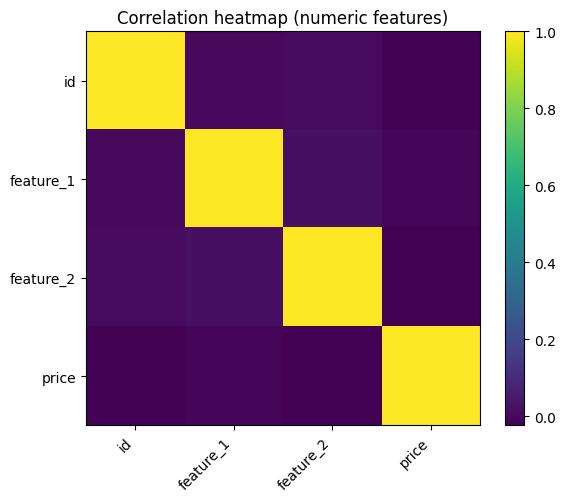

In [26]:
# Cell 13: quick EDA and thumbnail (requires matplotlib)
import matplotlib.pyplot as plt
df = pd.read_csv(res["csv"])
# numeric subset
num = df.select_dtypes(include=[np.number])
if not num.empty and num.shape[1] >= 2:
    corr = num.corr()
    plt.figure(figsize=(6,5))
    plt.title("Correlation heatmap (numeric features)")
    plt.imshow(corr, interpolation='nearest')
    plt.colorbar()
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
    plt.yticks(range(len(corr.columns)), corr.columns)
    thumb_path = res["csv"].replace(".csv","_heatmap.png")
    plt.tight_layout()
    plt.savefig(thumb_path, dpi=150)
    print("Heatmap saved to:", thumb_path)
else:
    print("Not enough numeric columns for correlation heatmap.")


In [27]:
# Cell 14: show where files are and how to download in Colab
print("CSV:", res["csv"])
print("Metadata YAML keys / sample:")
print(json.dumps(res["metadata"], indent=2)[:1000])
# Zipping package (optional)
import shutil
artifact = res["csv"].replace(".csv","")
zip_path = f"{artifact}_package.zip"
shutil.make_archive(artifact, 'zip', root_dir="/content", base_dir=os.path.basename(res["csv"]))
print("Package (zip) created:", zip_path)


CSV: /content/dataforge_build_me_a_dataset_for_predicting_airbnb_20251122T082705Z_8d5244.csv
Metadata YAML keys / sample:
{
  "id": "dataforge_build_me_a_dataset_for_predicting_airbnb_20251122T082705Z_8d5244",
  "title": "dataforge_build_me_a_dataset_for_predicting_airbnb_20251122T082705Z_8d5244",
  "prompt": "Build me a dataset for predicting Airbnb rental prices in Bangalore 2025 with bedrooms, location, amenities, reviews, nights_booked, price",
  "schema": [
    {
      "name": "id",
      "type": "int",
      "description": "unique id",
      "example": 1
    },
    {
      "name": "feature_1",
      "type": "float",
      "description": "auto feature",
      "example": 0.0
    },
    {
      "name": "feature_2",
      "type": "float",
      "description": "auto feature",
      "example": 0.0
    },
    {
      "name": "price",
      "type": "float",
      "description": "target price if applicable",
      "example": 1000.0
    }
  ],
  "created_at": "2025-11-22T08:27:05.112981+00

In [28]:
# Validation A: reproducibility manifest
import json, hashlib, os
from datetime import datetime

csv_path = res['csv']  # replace with your run result path variable if different
meta = res['metadata']  # orchestrator metadata

# compute checksum
def sha256_file(path):
    h = hashlib.sha256()
    with open(path,'rb') as f:
        for b in iter(lambda: f.read(65536), b''):
            h.update(b)
    return h.hexdigest()

manifest = {
    "dataset_csv": os.path.basename(csv_path),
    "sha256": sha256_file(csv_path),
    "rows": meta.get("rows"),
    "schema": [c['name'] for c in meta.get("schema",[])],
    "prompt": meta.get("prompt"),
    "seed": SEED,
    "created_at": datetime.utcnow().isoformat() + "Z",
    "fallback_used": meta.get("fallback_used", False),
    "generator_details": meta.get("provenance", {}),
    "llm_used": USE_GEMINI
}

with open(csv_path.replace(".csv",".manifest.json"), "w") as f:
    json.dump(manifest, f, indent=2)

print("Manifest saved:", csv_path.replace(".csv",".manifest.json"))
print(json.dumps(manifest, indent=2))


Manifest saved: /content/dataforge_build_me_a_dataset_for_predicting_airbnb_20251122T082705Z_8d5244.manifest.json
{
  "dataset_csv": "dataforge_build_me_a_dataset_for_predicting_airbnb_20251122T082705Z_8d5244.csv",
  "sha256": "85ead620a68f22c35fb3ee48bcea97c34990c8a78a732e54b93e8fcd1a1caba4",
  "rows": 8000,
  "schema": [
    "id",
    "feature_1",
    "feature_2",
    "price"
  ],
  "prompt": "Build me a dataset for predicting Airbnb rental prices in Bangalore 2025 with bedrooms, location, amenities, reviews, nights_booked, price",
  "seed": 12345,
  "created_at": "2025-11-22T08:35:08.475869Z",
  "fallback_used": true,
  "generator_details": {
    "synthetic": true,
    "method": "task_aware"
  },
  "llm_used": true
}


In [29]:
# Validation B: summary stats
import pandas as pd, numpy as np
df = pd.read_csv(res['csv'])
summary = df.describe(include='all').to_dict()
missing = df.isnull().sum().to_dict()
col_types = df.dtypes.apply(lambda x: str(x)).to_dict()
val_report = {"summary": summary, "missing": missing, "dtypes": col_types}
with open(res['csv'].replace(".csv",".summary.json"), "w") as f:
    json.dump(val_report, f, indent=2)
print("Summary saved:", res['csv'].replace(".csv",".summary.json"))
# Show concise summary
for col in df.columns:
    print(f"{col}: type={df[col].dtype}, missing={missing[col]}, sample={df[col].dropna().sample(n=min(3,len(df[col].dropna())), random_state=42).tolist()}")


Summary saved: /content/dataforge_build_me_a_dataset_for_predicting_airbnb_20251122T082705Z_8d5244.summary.json
id: type=int64, missing=0, sample=[2216, 2583, 1663]
feature_1: type=float64, missing=0, sample=[1976.49, 1287.27, 384.38]
feature_2: type=float64, missing=0, sample=[9424.04, 5326.54, 4924.92]
price: type=float64, missing=0, sample=[139588.99, 137031.36, 140030.6]


KS results: {
  "id": {
    "n": 8000,
    "mean": 4000.5,
    "std": 2309.401058716307,
    "ks_stat": 0.05726922256752298,
    "pvalue": 3.008105041848628e-23
  },
  "feature_1": {
    "n": 8000,
    "mean": 5017.878011250001,
    "std": 2895.543876386832,
    "ks_stat": 0.05677951090291533,
    "pvalue": 7.363414121924912e-23
  },
  "feature_2": {
    "n": 8000,
    "mean": 4970.48821125,
    "std": 2879.746153428443,
    "ks_stat": 0.05831491058135552,
    "pvalue": 4.334179719019119e-24
  },
  "price": {
    "n": 8000,
    "mean": 140079.90110624998,
    "std": 10031.061936429129,
    "ks_stat": 0.007908722650037114,
    "pvalue": 0.695818644742767
  }
}


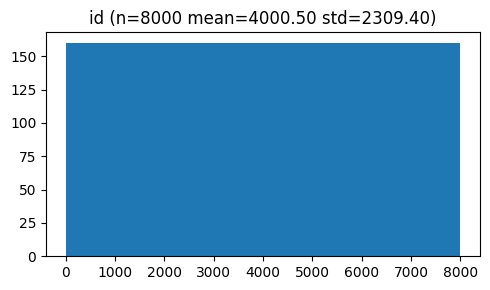

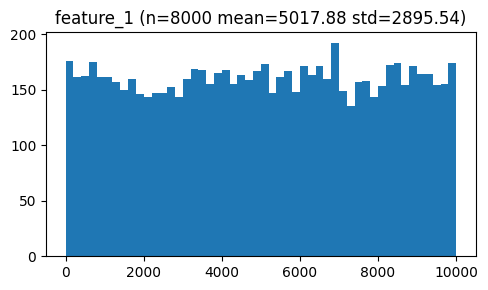

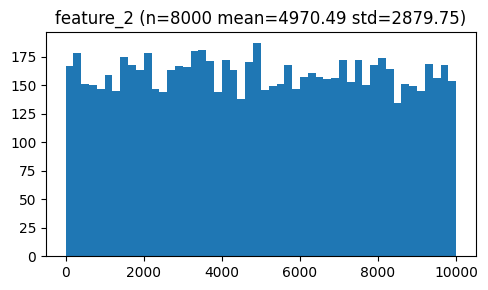

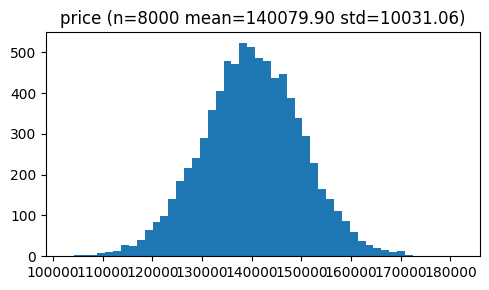

In [30]:
# Validation C: distributions + KS tests
import matplotlib.pyplot as plt
from scipy import stats
num = df.select_dtypes(include=[np.number])
ks_results = {}
for col in num.columns:
    vals = num[col].dropna().values
    if len(vals) < 50:
        continue
    # fit to normal as a quick sanity check
    mu, std = vals.mean(), vals.std()
    ks_stat, pvalue = stats.kstest((vals - mu)/std, 'norm')  # normalized KS vs normal
    ks_results[col] = {"n": len(vals), "mean": float(mu), "std": float(std), "ks_stat": float(ks_stat), "pvalue": float(pvalue)}
    # plot histogram
    plt.figure(figsize=(5,3))
    plt.hist(vals, bins=50)
    plt.title(f"{col} (n={len(vals)} mean={mu:.2f} std={std:.2f})")
    plt.tight_layout()
    plt.savefig(res['csv'].replace(".csv", f"_{col}_hist.png"))
print("KS results:", json.dumps(ks_results, indent=2))
with open(res['csv'].replace(".csv",".ks.json"), "w") as f:
    json.dump(ks_results, f, indent=2)


In [31]:
# Validation D: baseline with bootstrap CI
import numpy as np, joblib
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# choose numeric features automatically, drop target
target = meta.get("validation",{}).get("target", "price") if isinstance(meta.get("validation",{}), dict) else "price"
if target not in df.columns:
    # choose a numeric column as proxy (first numeric)
    target = df.select_dtypes(include=[np.number]).columns[-1]
print("Using target:", target)

X = df.select_dtypes(include=[np.number]).drop(columns=[target], errors='ignore').fillna(0)
y = df[target].fillna(0)
if X.shape[1] == 0:
    print("No numeric features for baseline")
else:
    # single-run baseline
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
    model = LinearRegression().fit(X_train, y_train)
    baseline_r2 = r2_score(y_test, model.predict(X_test))
    # bootstrap
    n_boot = 100
    boot_r2 = []
    rng = np.random.RandomState(SEED)
    for i in range(n_boot):
        idx = rng.choice(len(X_train), size=len(X_train), replace=True)
        m = LinearRegression().fit(X_train.iloc[idx], y_train.iloc[idx])
        boot_r2.append(r2_score(y_test, m.predict(X_test)))
    lo = np.percentile(boot_r2, 2.5)
    hi = np.percentile(boot_r2, 97.5)
    print(f"Baseline R2: {baseline_r2:.4f}, 95% CI [{lo:.4f}, {hi:.4f}]")
    with open(res['csv'].replace(".csv",".baseline.json"), "w") as f:
        json.dump({"r2": baseline_r2, "r2_ci": [lo, hi], "n_boot": n_boot}, f, indent=2)


Using target: price
Baseline R2: -0.0028, 95% CI [-0.0062, -0.0010]


In [32]:
# Validation E: data profiling (optional heavy)
!pip install -q ydata-profiling
from ydata_profiling import ProfileReport
profile = ProfileReport(df, title="DataForge profiling", minimal=True)
profile.to_file(res['csv'].replace(".csv","_profile.html"))
print("Profile saved:", res['csv'].replace(".csv","_profile.html"))


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 4/4 [00:00<00:00, 231.54it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Profile saved: /content/dataforge_build_me_a_dataset_for_predicting_airbnb_20251122T082705Z_8d5244_profile.html


In [33]:
# Validation F: create human_review.json for sign-off
hr = {
    "dataset": os.path.basename(res['csv']),
    "reviewer": "",
    "review_date": None,
    "issues_found": [],
    "accept": None,
    "notes": "Please inspect distributions and column semantics. If synthetic, check provenance."
}
with open(res['csv'].replace(".csv",".human_review.json"), "w") as f:
    json.dump(hr, f, indent=2)
print("Human review template saved:", res['csv'].replace(".csv",".human_review.json"))


Human review template saved: /content/dataforge_build_me_a_dataset_for_predicting_airbnb_20251122T082705Z_8d5244.human_review.json
